In [451]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel,RBF,GenericKernelMixin
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import os
from sklearn.model_selection import GridSearchCV,LeaveOneGroupOut
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [452]:
EIS_Data=os.listdir(path='EIS_data/EIS_Data')
Capacity_Data=os.listdir(path='Capacity_data/Capacity_Data')

In [453]:
path='./Capacity_data/Capacity_Data/'+ Capacity_Data[4]
cap= pd.read_table(path, delimiter='\t')
cap = cap.dropna(axis=1, how='all')
cap.head()
str(Capacity_Data[0])[14:19]

'25C01'

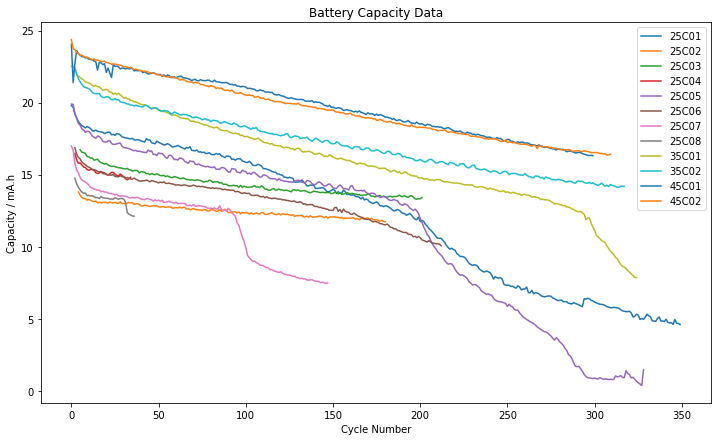

In [454]:

plt.figure(figsize=(12,7))
plt.title(label='Battery Capacity Data')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity / mA.h')
cap_merge = []
for i in range(len(Capacity_Data)):
    path='./Capacity_data/Capacity_Data/'+ Capacity_Data[i]
    cap= pd.read_table(path, delimiter='\t')
    cap = cap.dropna(axis=1, how='all')
    
    
    if len(cap.columns) <= 4:
        cap.columns = ['time/s', 'cycle number', 'ox/red', 'Capacity/mA.h']
    
    cap['temp'] = int(str(Capacity_Data[i])[14:16])
    cap['battery_num'] = int(str(Capacity_Data[i])[17:19])


    cap.columns = cap.columns.str.strip()
    cap = cap.dropna(subset=['time/s','cycle number', 'Capacity/mA.h'])
    cap_merge.append(cap)

    #print(cap.columns, i)
    cap = cap.groupby('cycle number').mean()
    mean = np.mean(cap['Capacity/mA.h'])
    std = np.std(cap['Capacity/mA.h'])

    # Define a threshold to identify outliers
    threshold = 2.5

    # Identify outliers by comparing values with the mean and standard deviation
    outliers = []
    for j, value in enumerate(cap['Capacity/mA.h']):
        z_score = (value - mean) / std
        if abs(z_score) > threshold:
            outliers.append(j)

    # Remove the outliers from the DataFrame
    cap = cap.drop(outliers)
    cap_mean = cap
    
    cap_mean = cap_mean.reset_index().rename(columns={'index': 'cycle number'})
    sns.lineplot(x = cap_mean['cycle number'], y = cap_mean['Capacity/mA.h'], label = str(Capacity_Data[i])[14:19] )

cap_merge = pd.concat(cap_merge, ignore_index=True)

plt.legend()
plt.show()


In [455]:
dfs = []
directory = './EIS_data/EIS_Data/'
def roman(numeral):
    roman_values = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    total = 0
    prev_value = 0
    for i in range(len(numeral) - 1, -1, -1):
        curr_value = roman_values[numeral[i]]
        if curr_value < prev_value:
            total -= curr_value
        else:
            total += curr_value
        prev_value = curr_value
    return total

# iterate over each file in the directory
for file in os.listdir(path = './EIS_data/EIS_Data/'):
    if file.endswith('.txt'):

        state = file.split('_')[2]
        temperature = int(file.split('_')[3][:-7])
        battery_num = int(file.split('_')[3][-6:-4])
        
        # read the file as a dataframe
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        
        # add new columns for state, temperature, and battery number
        df['state'] = roman(state)
        df['temperature'] = temperature
        df['battery_num'] = battery_num
        
        # append the modified dataframe to the list
        dfs.append(df)

# concatenate all dataframes in the list
result_df = pd.concat(dfs, ignore_index=True)
EIS_df = result_df
EIS_df.columns = EIS_df.columns.str.strip()
CAP_df = cap_merge

In [456]:
EIS_df


,time/s,cycle number,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,state,temperature,battery_num
0,9.651003e+03,1.0,20004.45300,0.39182,-0.03055,0.39301,4.45806,3,25,1
1,9.651146e+03,1.0,15829.12600,0.39693,-0.01230,0.39712,1.77458,3,25,1
2,9.651288e+03,1.0,12516.70300,0.40190,0.00234,0.40191,-0.33358,3,25,1
3,9.651430e+03,1.0,9909.44240,0.40953,0.01629,0.40986,-2.27833,3,25,1
4,9.651594e+03,1.0,7835.48000,0.41789,0.02743,0.41879,-3.75550,3,25,1
...,...,...,...,...,...,...,...,...,...,...
1175931,4.667724e+06,310.0,0.05102,0.96737,0.18275,0.98448,-10.69807,5,45,2
1175932,4.667751e+06,310.0,0.04042,0.99667,0.20892,1.01833,-11.83900,5,45,2
1175933,4.667786e+06,310.0,0.03192,1.03304,0.24706,1.06217,-13.45032,5,45,2
1175934,4.667829e+06,310.0,0.02528,1.06369,0.29246,1.10316,-15.37371,5,45,2


In [457]:
EIS_df.columns

Index(['time/s', 'cycle number', 'freq/Hz', 'Re(Z)/Ohm', '-Im(Z)/Ohm',
       '|Z|/Ohm', 'Phase(Z)/deg', 'state', 'temperature', 'battery_num'],
      dtype='object')

In [458]:
df  = EIS_df[EIS_df['state']==5]

cycle_groups = df.groupby('cycle number')
# Use pivot_table to reshape the data
pivoted_chunks = []

# Pivot each chunk and append to list
for name, group in cycle_groups:
    chunk_pivot = pd.pivot_table(group, index=['cycle number', 'time/s', 'state', 'temperature', 'battery_num'], columns='freq/Hz', values=['Re(Z)/Ohm', '-Im(Z)/Ohm'])
    pivoted_chunks.append(chunk_pivot)

# Concatenate pivoted chunks back together into final DataFrame
df_pivot = pd.concat(pivoted_chunks)

# Flatten the column index
df_pivot.columns = [f'Real_{i}' for i in range(1,61)] + [f'Imag_{i}' for i in range(1,61)]

# Reset the index to make cycle number, time/s, and battery_num regular columns
df_pivot = df_pivot.reset_index()

# Merge the new columns with the original DataFrame
df_merged = pd.merge(df, df_pivot, on=['cycle number', 'time/s', 'state', 'temperature', 'battery_num'])



In [459]:
df_merged

,time/s,cycle number,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,state,temperature,battery_num,...,Imag_51,Imag_52,Imag_53,Imag_54,Imag_55,Imag_56,Imag_57,Imag_58,Imag_59,Imag_60
0,1.283673e+04,1.0,20004.45300,0.38470,-0.03513,0.38630,5.21784,5,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3847
1,1.283687e+04,1.0,15829.12600,0.39156,-0.01700,0.39193,2.48562,5,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39156,NaN
2,1.283701e+04,1.0,12516.70300,0.39684,0.00009,0.39684,-0.01302,5,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39684,NaN,NaN
3,1.283715e+04,1.0,9909.44240,0.40341,0.01405,0.40365,-1.99482,5,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.40341,NaN,NaN,NaN
4,1.283732e+04,1.0,7835.48000,0.40963,0.02612,0.41046,-3.64787,5,25,1,...,NaN,NaN,NaN,NaN,NaN,0.40963,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167275,4.667724e+06,310.0,0.05102,0.96737,0.18275,0.98448,-10.69807,5,45,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167276,4.667751e+06,310.0,0.04042,0.99667,0.20892,1.01833,-11.83900,5,45,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167277,4.667786e+06,310.0,0.03192,1.03304,0.24706,1.06217,-13.45032,5,45,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167278,4.667829e+06,310.0,0.02528,1.06369,0.29246,1.10316,-15.37371,5,45,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [460]:
# Group the data by temperature, cycle number, battery_num, and time and combine all frequencies into a single row
df_grouped = df_merged.groupby(['cycle number','battery_num','temperature']).sum()

df_grouped = df_grouped.reset_index()

In [461]:
final_df = df_grouped.iloc[:, :] 
column_order = [col for col in final_df.columns if col != 'cycle number'] + ['cycle number']
final_df = final_df[column_order]

In [462]:
final_cap_df = CAP_df.groupby(['cycle number','battery_num','temp']).max()
final_cap_df = final_cap_df.reset_index()
final_cap_df= final_cap_df.rename(columns={'temp': 'temperature'})

In [463]:
df_merged = pd.merge(final_df, final_cap_df[['cycle number', 'battery_num', 'temperature', 'Capacity/mA.h']], 
                     on=['cycle number', 'battery_num', 'temperature'], how='left')

In [464]:
df_merged

,battery_num,temperature,time/s,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,state,Real_1,...,Imag_53,Imag_54,Imag_55,Imag_56,Imag_57,Imag_58,Imag_59,Imag_60,cycle number,Capacity/mA.h
0,1,25,7.717691e+05,95814.68881,48.94783,6.37302,49.48320,-444.58293,300,0.32795,...,0.43530,0.42764,0.41925,0.40963,0.40341,0.39684,0.39156,0.38470,1.0,36.720858
1,1,35,7.809415e+05,95814.68881,34.49654,4.56595,34.89765,-437.02827,300,0.27584,...,0.32075,0.31213,0.30467,0.29889,0.29203,0.28649,0.28167,0.27500,1.0,39.903776
2,1,45,8.362652e+05,95814.68881,107.38984,3.49049,107.48156,-108.00842,300,0.24432,...,1.60733,1.60032,1.59583,1.58947,1.58275,1.57973,1.57370,1.56984,1.0,42.067485
3,2,25,7.694650e+05,95814.68881,57.45839,9.54495,58.51382,-639.37391,300,0.35528,...,0.34554,0.33337,0.31906,0.31009,0.29896,0.28916,0.28005,0.27315,1.0,33.598674
4,2,35,7.866346e+05,95814.68881,46.22656,4.57607,46.53008,-326.35714,300,0.27295,...,0.51411,0.50724,0.49981,0.49372,0.48775,0.48147,0.47585,0.47084,1.0,40.145574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,1,35,2.773549e+08,95814.68881,48.55175,9.70650,49.67614,-636.77075,300,0.58656,...,0.36173,0.35279,0.34543,0.33537,0.32774,0.31853,0.31116,0.30037,323.0,22.775308
2784,1,35,2.780916e+08,95814.68881,48.56352,9.75026,49.69931,-637.88356,300,0.58331,...,0.36176,0.35350,0.34768,0.33806,0.32879,0.31792,0.31019,0.30154,324.0,22.717943
2785,1,35,2.788279e+08,95814.68881,48.76265,9.85805,49.91791,-642.78494,300,0.56485,...,0.36120,0.35405,0.34403,0.33840,0.32922,0.32065,0.31053,0.30325,325.0,22.556691
2786,1,35,2.795627e+08,95814.68881,48.79857,9.76931,49.91739,-640.05241,300,0.51995,...,0.36337,0.35399,0.34515,0.33637,0.32863,0.32026,0.31105,0.30322,326.0,22.375020


In [465]:
df_merged = df_merged.dropna()
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df_merged.loc[:, 'Capacity/mA.h'] = scaler.fit_transform(df_merged[['Capacity/mA.h']])


ds = df_merged[df_merged['temperature'] == 25]
ds = ds[ds['battery_num']<=4]
ds = ds.groupby(['cycle number', 'battery_num']).mean().reset_index()
X_train = ds.iloc[:, -121:-1]
y_train = ds.iloc[:, -1:]
y_train

ds2 = df_merged[df_merged['temperature'] == 25]
ds2 = ds2[ds2['battery_num']==5]
ds2 = ds2.groupby(['cycle number', 'battery_num']).mean().reset_index()
X_test = ds2.iloc[:, -121:-1]
y_test = ds2.iloc[:, -1:]
cycle_test = ds2.iloc[:, 0]
cycle_test

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
       ...  
270    271.0
271    272.0
272    273.0
273    274.0
274    275.0
Name: cycle number, Length: 275, dtype: float64

0.807314497447104
2.089964659551613
275 275


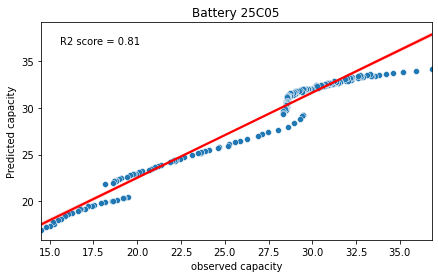

In [466]:
from sklearn.metrics import r2_score


gp=GaussianProcessRegressor(alpha=40,kernel=5*RBF(),n_restarts_optimizer=5)

gp.fit(X_train,y_train)
y_pred=gp.predict(X_test)
#y_pred=scaler_y.inverse_transform(y_pred)


testing_cells=[X_test]
testing_caps=[y_test]


for i,j in zip(testing_cells,testing_caps):
    y_pred=np.ravel(gp.predict(i))
    print(r2_score(j,y_pred))
    print(np.sqrt(mean_squared_error(j,y_pred)))
    print(len(j), len(y_pred))
    plt.figure(figsize=(7,4))
    y_obs = np.ravel(np.array(j))
    #sns.scatterplot(x=y_obs, y=np.ravel(y_pred))
    #plt.plot(y_pred)
    
# Calculate R-squared score
    r2 = r2_score(y_obs, y_pred)

    # Create scatter plot
    plt.xlabel('observed capacity')
    plt.ylabel('Predicted capacity')
    plt.title('Battery 25C05')
    sns.scatterplot(x=y_obs, y=y_pred)

    # Add R-squared score to plot
    plt.text(0.05, 0.9, f'R2 score = {r2:.2f}', transform=plt.gca().transAxes)
    sns.regplot(x=y_obs, y=y_pred, scatter=False, color='red')

    # Show plot
    plt.show()

275 275 275


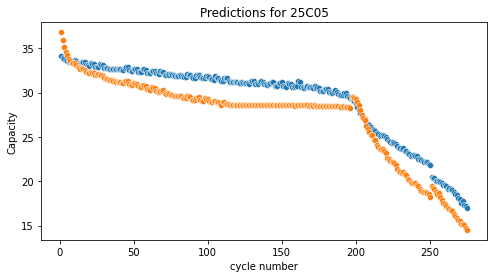

In [467]:
plt.figure(figsize=(8,4))
plt.ylabel('Capacity')
plt.title('Predictions for 25C05')
sns.scatterplot(x=cycle_test, y=y_pred)
sns.scatterplot(x=cycle_test, y=y_obs)
print(len(cycle_test),len(y_obs), len(y_pred ))

In [468]:
ds

,cycle number,battery_num,temperature,time/s,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,state,...,Imag_52,Imag_53,Imag_54,Imag_55,Imag_56,Imag_57,Imag_58,Imag_59,Imag_60,Capacity/mA.h
0,1.0,1,25,7.717691e+05,95814.68881,48.94783,6.37302,49.48320,-444.58293,300,...,0.44525,0.43530,0.42764,0.41925,0.40963,0.40341,0.39684,0.39156,0.38470,36.720858
1,1.0,2,25,7.694650e+05,95814.68881,57.45839,9.54495,58.51382,-639.37391,300,...,0.36048,0.34554,0.33337,0.31906,0.31009,0.29896,0.28916,0.28005,0.27315,33.598674
2,1.0,3,25,7.530995e+05,95814.68881,60.52373,10.57701,61.69925,-677.07038,300,...,0.36510,0.34957,0.33503,0.32041,0.31003,0.29862,0.28738,0.27977,0.26859,36.209368
3,1.0,4,25,7.635218e+05,95814.68881,57.34750,9.97249,58.45565,-667.99092,300,...,0.35150,0.33718,0.32314,0.31111,0.30112,0.29147,0.28046,0.27469,0.26546,34.822135
4,2.0,1,25,1.733988e+06,95814.68881,49.39279,6.41898,49.92720,-445.23097,300,...,0.45061,0.44032,0.43087,0.42210,0.41472,0.40798,0.40066,0.39343,0.38886,35.911835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,257.0,1,25,2.195955e+08,95814.68881,61.70367,10.78063,62.82640,-559.68392,300,...,0.49533,0.48721,0.47832,0.46996,0.46209,0.45501,0.44852,0.44075,0.43417,21.705267
672,258.0,1,25,2.203362e+08,95814.68881,61.80511,10.85808,62.94380,-561.30095,300,...,0.49667,0.48812,0.47991,0.47139,0.46417,0.45760,0.44924,0.44219,0.43382,20.425451
673,259.0,1,25,2.210630e+08,95814.68881,61.49934,10.76861,62.62321,-559.83309,300,...,0.49751,0.48686,0.47927,0.47092,0.46293,0.45533,0.44736,0.44172,0.43526,20.532946
674,260.0,1,25,2.217909e+08,95814.68881,61.33732,10.77672,62.47003,-560.21222,300,...,0.49556,0.48637,0.47819,0.47021,0.46272,0.45477,0.44843,0.44133,0.43485,20.555266


0.8437840359606775
31.376312807208727
275 275


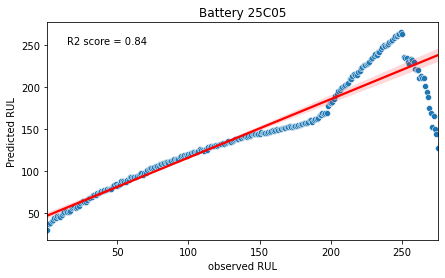

In [470]:
ds = df_merged[df_merged['temperature'] == 25]
ds = ds[ds['battery_num']<=4]
ds = ds.groupby(['cycle number', 'battery_num']).mean().reset_index()
X_train = ds.iloc[:, -121:-1]
y_train = ds.iloc[:, 0]
y_train

ds2 = df_merged[df_merged['temperature'] == 25]
ds2 = ds2[ds2['battery_num']==5]
ds2 = ds2.groupby(['cycle number', 'battery_num']).mean().reset_index()
X_test = ds2.iloc[:, -121:-1]
y_test = ds2.iloc[:, 0]
cycle_test = ds2.iloc[:, 0]
cycle_test

from sklearn.metrics import r2_score


gp=GaussianProcessRegressor(alpha=40,kernel=5*RBF(),n_restarts_optimizer=5)

gp.fit(X_train,y_train)
y_pred=gp.predict(X_test)
#y_pred=scaler_y.inverse_transform(y_pred)


testing_cells=[X_test]
testing_caps=[y_test]


for i,j in zip(testing_cells,testing_caps):
    y_pred=np.ravel(gp.predict(i))
    print(r2_score(j,y_pred))
    print(np.sqrt(mean_squared_error(j,y_pred)))
    print(len(j), len(y_pred))
    plt.figure(figsize=(7,4))
    y_obs = np.ravel(np.array(j))
    #sns.scatterplot(x=y_obs, y=np.ravel(y_pred))
    #plt.plot(y_pred)
    
# Calculate R-squared score
    r2 = r2_score(y_obs, y_pred)
    plt.xlabel('observed RUL')
    plt.ylabel('Predicted RUL')
    plt.title('Battery 25C05')

    # Create scatter plot
    sns.scatterplot(x=y_obs, y=y_pred)


    # Add R-squared score to plot
    plt.text(0.05, 0.9, f'R2 score = {r2:.2f}', transform=plt.gca().transAxes)
    sns.regplot(x=y_obs, y=y_pred, scatter=False, color='red')

    # Show plot
    plt.show()